# Deutsch-Jozsa algorithm

## Recap

In this algorithm, we are given a Boolean function $f$, which takes as input a bitstring and returns
either 0 or 1.

The given $f$ can be either:
- constant, i.e., it will always yields the same output value for any input
- balanced, i.e., it will yield 0 when it is evaluated in half of the input configurations and 1 when it is evaluated in the other half – there are ( 2n

Our goal is to determine whether the given function is balanced or constant.

## Abstract circuit

In [7]:
from qat.lang.AQASM import *

We start by definining an abstract oracle gate.

In [51]:
# This gates accept an int as parameter. It will contain the number of qubits
my_oracle = AbstractGate("MyOracle", [int])

We proceed by defining our circuit. Here `nqubits` is a parameter that can vary (but don't go beyond 20 for the sake of your laptop!)

In [52]:
nqubits = 5

pr = Program()
qr = pr.qalloc(nqubits)
qout = pr.qalloc(1)

pr.apply(X, qout)
pr.apply(H, qout)

for qb in qr:
    pr.apply(H, qb)
# Note how we apply the oracle even if it is not defined
pr.apply(my_oracle(nqubits), [*qr, *qout])
for qb in qr:
    pr.apply(H, qb)
pr.apply(H, qout)
pr.apply(X, qout)

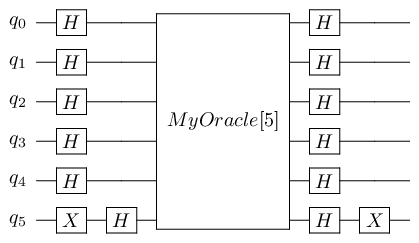

In [53]:
circ = pr.to_circ()
%qatdisplay circ

At this point, if we try to simulate the circuit, we will have an exception since we do not have a valid implementation of the abstract gate in terms of standard gates.

In [54]:
from qat.qpus import PyLinalg
qpu = PyLinalg()

In [55]:
try:
    qpu.submit(circ.to_job())
except:
    import traceback
    traceback.print_exc(limit=1)

Traceback (most recent call last):
  File "/mnt/internal/LinuxData/pyenv/versions/3.9.10/envs/myqlm9/lib/python3.9/site-packages/qat/pylinalg/simulator.py", line 154, in simulate
    nctrls, matrix = get_gate_matrix(gdef, circuit.gateDic)
AttributeError: 'NoneType' object has no attribute 'nRows'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_71970/2240548949.py", line 2, in <cell line: 1>
    qpu.submit(circ.to_job())
qat.comm.exceptions.ttypes.QPUException: QPUException(code=11, modulename='qat.pylinalg', message='Gate MyOracle has no matrix!', file='qat/pylinalg/simulator.py', line=103)


## Oracles

Let's now define the two oracles we need. First one is a constant oracle. It doesn't apply any gate at all, so it will produce always the same result at its output.

In [56]:
@build_gate("MyOracle", [int])
def constant_zero_oracle(nqubits):
    qrout = QRoutine()
    qreg = qrout.new_wires(nqubits)
    qout = qrout.new_wires(1)
    return qrout

*There is another oracle of this kind. Can you produce it?*

The second one, instead, is a balanced oracle. The simplest way to produce this kind of oracle is through the following circuit (*can you guess why?*)

In [57]:
@build_gate("MyOracle", [int], arity=lambda n:n)
def balanced_oracle(nqubits):
    qrout = QRoutine()
    qreg = qrout.new_wires(nqubits)
    qout = qrout.new_wires(1)
    for qb in qreg:
        qrout.apply(CNOT, qb, qout)
        
    return qrout

Note the usage of the `arity` parameter in the previous cell. Indeed, for gates of variable arities (i.e., number of qubits it acts on) it is possible to specify an `arity_generator` to the `AbstractGate` constructor. In this way, we give more information to `pyAQASM` in order to statically detect potential mistakes during the circuit construction. Also, we can display the circuit. 

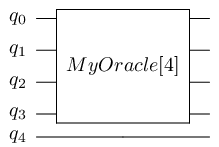

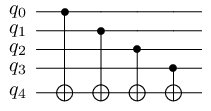

In [58]:
example = balanced_oracle(4)
%qatdisplay example
%qatdisplay example --depth 1

## Simulation

Let's now simulate the circuit. In this case, we use a nice feature of myQLM called linking. It allows to bind any abstract gate definition to a function producing a circuit implemented through standard quantum gates.

The first linked circuit will be the constant zero oracle.

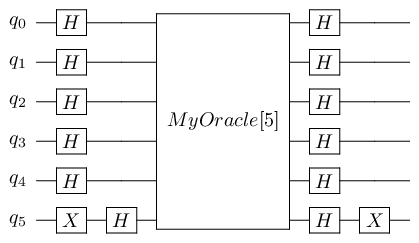

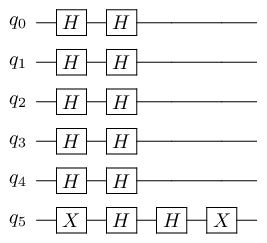

In [60]:
circ = pr.to_circ(link=[constant_zero_oracle])
%qatdisplay circ
%qatdisplay circ --depth=1

In [61]:
res = qpu.submit(circ.to_job())
for sample in res:
    print(f"State {sample.state} with amplitude {sample.amplitude}")

State |00000>|0> with amplitude (0.999999999999999+0j)


We can also just sample `qr` to get probabilities instead of amplitudes.

In [62]:
res = qpu.submit(circ.to_job(qubits=[qr]))
for sample in res:
    print(f"State {sample.state} with probability {sample.probability}")

State |00000> with probability 0.999999999999998


Let's see the result for the balanced oracle.

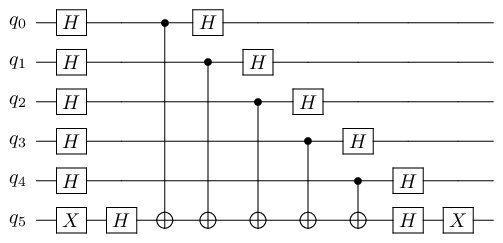

In [64]:
circ = pr.to_circ(link=[balanced_oracle])
%qatdisplay circ --depth 1

In [65]:
res = qpu.submit(circ.to_job())
for sample in res:
    print(f"State {sample.state} with amplitude {sample.amplitude}")

State |11111>|0> with amplitude (0.999999999999999+0j)


As before, we can just sample `qr` to get the probability.

In [66]:
res = qpu.submit(circ.to_job(qubits=[qr]))
for sample in res:
    print(f"State {sample.state} with amplitude {sample.probability}")

State |11111> with amplitude 0.999999999999998
